# Recurrent Neural Network

Gerald Baulig 0780827 2019/12/24

GitHub: https://github.com/bugerry87/fcnn_scratch

---

In this assignment we were asked to implement a Reccurent Neural Network (RNN).
We will use an RNN and sub-versions of RNN such as LSTM for naiv text generating.
An RNN is a Neural Network with a feedback loop and therewith useful to perform on sequential data.
General speaking, an RNN concartinates its own output with the input of the next (time)-frame continuously to a finite number of iterations, mostly definde by the sequence length.
A typical use case and implemented in this assignment is to predict the next symbol, based on a given sequence of symbols.

The dataset we have to process in this assignment is a section of a Shakespear's Coriolanus, but could be also any other kind of structured text. Ensure, the `data` folder has these two files:

    shakespeare_train.txt
    shakespeare_valid.txt

Furthermore, preinstall the following packages:

In [1]:
## Global imports
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

print("Tested Tensorflow Version: 2.0")
print("Current Tensorflow Version:", tf.__version__)

Tested Tensorflow Version: 2.0
Current Tensorflow Version: 2.0.0


## Data Preparation

To enable our RNN to read and to write, we need to vectorize our text and keep a dictionary from the vectoriztion, such that we are able to translate back to human-readable text.
UTF-8 covers 128 symbols, however, our treining text is only using a part of this set.
The usage of symbols that are not included in out training text woun't never be learned.
Hence, we can ignore those.
The vectoraziation squeezes the set of symboles to a required minimal set.
By doing so, the hot-vector for the cross-entopy will be smaller and therewith our final model.

In [2]:
def load_data(filename, verbose=False):
    with open(filename, 'rb') as fid:
        text = fid.read()
        pass
    np_text = np.array(list(text))
    vocab = np.unique(list(text))
    vocab_dict = {c:i for i, c in enumerate(vocab)}
    vec_text = np.array([vocab_dict[c] for c in np_text])
    if verbose:
        print("\n--- Plain Text:", len(text), "---\n", text[:100].decode('utf-8'), "...")
        print("\n--- Numpy Array:", np_text.shape, "---\n", np_text[:100], "...")
        print("\n--- Vocabular:", vocab.shape, "---\n", vocab[:10], "...")
        print("\n--- Dictionary ---\n", vocab_dict)
        print("\n--- Vectorized Text:", vec_text.shape, "---\n", vec_text[:100], "...")
    return vec_text, vocab, vocab_dict

## Run!
val, _, _ = load_data('data/shakespeare_valid.txt', True)
train, vocab, vocab_dict = load_data('data/shakespeare_train.txt')


--- Plain Text: 229972 ---
 DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The a ...

--- Numpy Array: (229972,) ---
 [ 68  85  75  69  32  79  82  83  73  78  79  58  13  10  73 102  32 109
 117 115 105  99  32  98 101  32 116 104 101  32 102 111 111 100  32 111
 102  32 108 111 118 101  44  32 112 108  97 121  32 111 110  59  13  10
  71 105 118 101  32 109 101  32 101 120  99 101 115 115  32 111 102  32
 105 116  44  32 116 104  97 116  44  32 115 117 114 102 101 105 116 105
 110 103  44  13  10  84 104 101  32  97] ...

--- Vocabular: (63,) ---
 [10 13 32 33 39 44 45 46 58 59] ...

--- Dictionary ---
 {10: 0, 13: 1, 32: 2, 33: 3, 39: 4, 44: 5, 45: 6, 46: 7, 58: 8, 59: 9, 63: 10, 65: 11, 66: 12, 67: 13, 68: 14, 69: 15, 70: 16, 71: 17, 72: 18, 73: 19, 74: 20, 75: 21, 76: 22, 77: 23, 78: 24, 79: 25, 80: 26, 81: 27, 82: 28, 83: 29, 84: 30, 85: 31, 86: 32, 87: 33, 88: 34, 89: 35, 90: 36, 97: 37, 98: 38, 99: 39, 100: 40, 101: 41, 102: 42, 103

### Create Tensorflow Datagenerators

Such that the vectorized text can be easily used in the Keras-Tensorflow API,
we prepare some data-generators.
Those chunk our data to batches and randomize them.

In [3]:
def mapping(chunk):
    y = chunk[:-1]
    t = chunk[1:]
    return y, t

def create_datagenerator(data, chunk_sz, batch_sz, buffer_sz):
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.batch(chunk_sz+1, drop_remainder=True)
    dataset = dataset.map(mapping)
    dataset = dataset.shuffle(buffer_sz).batch(batch_sz, drop_remainder=True)
    return dataset

## Run!
chunk_size = 100
batch_size = 64

train_set = create_datagenerator(train, chunk_size, batch_size, buffer_sz=1000)
val_set = create_datagenerator(train, chunk_size, batch_size, buffer_sz=200)

print(val_set)
for batch in val_set.take(1):
    print("\n--- Input Y: ---\n", bytes([vocab[i] for i in batch[0].numpy()[0]]).decode('utf-8'))
    print("\n--- Target T: ---\n", bytes([vocab[i] for i in batch[1].numpy()[0]]).decode('utf-8'))

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int32, tf.int32)>

--- Input Y: ---
 deliberate,
Not rash like his accusers, and thus answer'd:
'True is it, my incorporate friends,' q

--- Target T: ---
 eliberate,
Not rash like his accusers, and thus answer'd:
'True is it, my incorporate friends,' qu


## Setup a SimpleRNN

Let's setup a most simple RNN with (just) 1024 units.
Fortunately, Keras provides an easy to use off-the-shalf RNN layer.
Since we want to generate text we require the `return_sequences` flag, instead of processing each character individualy.
Since we want to learn from the text with was already read, we activate the `stateful` flag.

We will observe that a simple RNN with 1024 units results in an already quite large network of +1M parameters.
However, this is a relatively small RNN compared to the future experiments with LSTM and GRU.

In [4]:
def setup_rnn(inp_dim, emb_dim, units, batch_sz):
    model = tf.keras.Sequential()
    model.add(layers.Embedding(inp_dim, emb_dim, batch_input_shape=[batch_sz, None]))
    model.add(layers.SimpleRNN(
        units,
        return_sequences=True,
        stateful=True,
        recurrent_initializer='glorot_uniform'
    ))
    model.add(layers.Dense(inp_dim))
    return model

def eval_acc(epoch, logs):
    print("Test:")
    eval = model.evaluate(x_test, y_test)
    logs['test_loss'] = eval[0]
    logs['test_acc'] = eval[1]
    print('Test loss:', eval[0], 'Test accuracy:', eval[1])

## Run!
inp_dim = vocab.size
emb_dim = 256
units = 1024
batch_size = 64

if 'model' in globals():
    print("Clean up old model!")
    tf.keras.backend.clear_session()
    del model

model = setup_rnn(inp_dim, emb_dim, units, batch_size)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           17408     
_________________________________________________________________
simple_rnn (SimpleRNN)       (64, None, 1024)          1311744   
_________________________________________________________________
dense (Dense)                (64, None, 68)            69700     
Total params: 1,398,852
Trainable params: 1,398,852
Non-trainable params: 0
_________________________________________________________________


## Train a SimpleRNN

We are asked to minimize our model to the so-called Bits-Per-Character (BPC) loss-function, which is literally the cross-entropy of two sequences:

$$
\begin{equation}
BPC = - \frac{1}{N} \sum_{n=1}^{N}\sum_{k=1}^{K} t_{nk} \log y_k (X_n, W)
\tag{7.1}
\end{equation}
$$

where $t$ is the target (ground truth) and $y$ our models prediction.
$N$ is the length of the sequence and $K$ the number of classes (or length of the vocabular), while $n$ denotes the delay.

Thanks to `Keras.sparse_categorial_crossentropy` we don't need to convert our label (the vectorized text) into a hot-vecter by our own. This makes the usage of our model much more photonic.

In [5]:
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint

def loss(labels, logits):
    return sparse_categorical_crossentropy(labels, logits, from_logits=True)

def run_training(model, trainset, valset, epochs, checkpoint):
    mc = ModelCheckpoint(
        filepath=checkpoint,
        save_weights_only=True
    )
    model.compile(optimizer='adam', loss=loss)
    return model.fit(trainset, epochs=epochs, validation_data=valset, callbacks=[mc])

## Run!
epochs = 10
checkpoint = './models/rnn_{epoch}'
history = run_training(model, train_set, val_set, epochs, checkpoint)

Epoch 1/10
697/697 [==============================] - 77s 111ms/step - loss: 2.0388 - val_loss: 0.0000e+00
Epoch 2/10
697/697 [==============================] - 76s 109ms/step - loss: 1.5605 - val_loss: 1.5384
Epoch 3/10
697/697 [==============================] - 77s 110ms/step - loss: 1.4437 - val_loss: 1.4630
Epoch 4/10
697/697 [==============================] - 77s 110ms/step - loss: 1.3888 - val_loss: 1.4189
Epoch 5/10
697/697 [==============================] - 77s 110ms/step - loss: 1.3564 - val_loss: 1.3882
Epoch 6/10
697/697 [==============================] - 77s 110ms/step - loss: 1.3353 - val_loss: 1.3721
Epoch 7/10
697/697 [==============================] - 77s 110ms/step - loss: 1.3190 - val_loss: 1.3549
Epoch 8/10
697/697 [==============================] - 76s 110ms/step - loss: 1.3068 - val_loss: 1.3458
Epoch 9/10
697/697 [==============================] - 77s 110ms/step - loss: 1.2966 - val_loss: 1.3429
Epoch 10/10
697/697 [==============================] - 77s 110ms/step

Here we observe that a simple RNN performes relatively fast with 77s per epoch or rather 111ms per step.
In this setup one step represents a batch of 64x100 characters.
Hence, this RNN processes 6400 characters in 111ms.
That implies ~57,657 per second.

We achieved an validation loss of `val_loss: 1.3301`.

## Plot Learning Curves

Let's plot the learning curves, which can be easily extracted from the `Keras.History`.

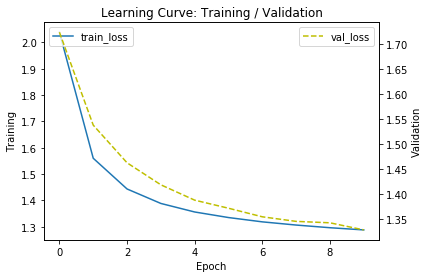

In [6]:
def plot_history(history):
    ## Plot Training Loss
    _, ax_l = plt.subplots(1)
    ax_l.plot(history.history['loss'], label='train_loss')
    ax_l.set_ylabel("Training")
    ax_l.set_xlabel("Epoch")
    ax_l.legend(loc=2)

    ## Plot Validation Loss
    ax_r = ax_l.twinx()
    ax_r.plot(history.history['val_loss'], 'y--', label='val_loss')
    ax_r.set_ylabel("Validation")
    ax_r.legend()
    
    plt.title("Learning Curve: Training / Validation")
    plt.show()

## Run!
plot_history(history)

We obtain a proper shaped learning curve with continuously progress.
The learning curve does not yet saturate, such that further epochs would be reasonable.

## Restore Checkpoint

Let's restore the model from a checkpoint with a `batch_size` of 1 for qualitative testing.

In [7]:
def restore_checkpoint(checkpoint, setup_lambda):
    model = setup_lambda()
    model.load_weights(checkpoint)
    model.build(tf.TensorShape([1, None]))
    return model

## Run!
if 'model' in globals():
    print("Clean up old model!")
    tf.keras.backend.clear_session()
    del model
    pass

model = restore_checkpoint(
    './models/rnn_10',
    lambda: setup_rnn(inp_dim, emb_dim, units, batch_sz=1)
)

model.summary()

Clean up old model!
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (1, None, 256)            17408     
_________________________________________________________________
simple_rnn (SimpleRNN)       (1, None, 1024)           1311744   
_________________________________________________________________
dense (Dense)                (1, None, 68)             69700     
Total params: 1,398,852
Trainable params: 1,398,852
Non-trainable params: 0
_________________________________________________________________


## Generate Text with RNN

Since our model is trained, we can employ it to either regenerate a given text-string, or even predict further characters beyond the given string.
The latter sounds like a more promising application for vairous use case.
Since our model is stateful we can simple inject on character after another
and for the prediction we keep injecting its own output, until we reached a given length.

In [8]:
def generate_text(model, seed, vocab, vocab_dict, grow=0, temp=1.0):
    if isinstance(seed, np.ndarray):
        vec_seed = seed
    elif isinstance(seed, tf.Tensor):
        vec_seed = seed
    else:
        #vectorize the seed string
        bseed = bytes(seed, 'utf-8')
        vec_seed = np.array([vocab_dict[c] for c in bseed])
        vec_seed = np.expand_dims(vec_seed, 0)
    pred_ids = []
    
    model.reset_states()
    if grow:
        for i in range(grow):
            pred = model.predict(vec_seed)
            pred = tf.squeeze(pred, 0)

            pred /= temp
            pred_id = tf.random.categorical(pred, num_samples=1)[-1,0].numpy()
            pred_ids.append(pred_id)
            vec_seed = tf.expand_dims(pred_id, 0)
        gen_text = seed + bytes([vocab[i] for i in pred_ids]).decode('utf-8')
    else:
        pred = model.predict(vec_seed)
        pred = np.squeeze(pred)
        pred_ids = np.argmax(pred, axis=1)
        gen_text = bytes([vocab[i] for i in pred_ids]).decode('utf-8')
    return gen_text

## Run!
text = generate_text(model, "JULIET", vocab, vocab_dict)
print(text)


OXLNXZ


## Compare Qualitatively

Now, since we are able to restore and generate text with our models, let's check some qualitative results.
Therefore, we simple take a sample from the datagenerator we've created before and inject it to our text generator function without a growth.
Then we compare binary each predicted symbol with the input symbol, shifted by 1.
By doing so, we obtain a metch-mask.
By taking the mean of the metch-mask, we obtain the averaged accuracy of how many symboles have been correctly predicted.

In [9]:
tf.autograph.set_verbosity(3)
tf.get_logger().setLevel('ERROR')

def eval_qualitatively(checkpoints, restore, sample, grow=0):
    for i, checkpoint in enumerate(checkpoints):
        model = restore_checkpoint(
            checkpoint,
            restore[i] if isinstance(restore, list) else restore
        )
        gen_text = generate_text(model, sample, vocab, vocab_dict, grow, 1)
        if grow:
            yield checkpoint, gen_text
        else:
            metches = np.array([a == b for a, b in zip(sample[1:], gen_text[:-1])])
            yield checkpoint, gen_text, metches
        del model
    pass

## Run!
checkpoints = [
        './models/rnn_2',
        './models/rnn_4',
        './models/rnn_6',
        './models/rnn_8',
        './models/rnn_10'
    ]

## Take a sample from the raining set
for batch in train_set.take(1):
    sample = bytes([vocab[i] for i in batch[0].numpy()[0]]).decode('utf-8')
print("\n--- Original Y: ---\n", sample)

for checkpoint, text, metches in eval_qualitatively(
    checkpoints,
    lambda: setup_rnn(inp_dim, emb_dim, units, batch_sz=1),
    sample
):
    print("\n--- Checkpoint: ", checkpoint, " Metch: ", (metches.mean()*100),"% ---\n", text)


--- Original Y: ---
 ld not
sell him an hour from her beholding, I, considering
how honour would become such a person. 

--- Checkpoint:  ./models/rnn_2  Metch:  55.55555555555556 % ---
 o,bot 
Thrl tim tndaonr ooom tir aeaold ng  a  tomstder ng 
Win tawour oirld te ome toch a prason 

--- Checkpoint:  ./models/rnn_4  Metch:  52.52525252525253 % ---
 o.bot 
bhrf tim tldeonr orom tir wraold ng  a  tomftder ng 
Taw tawour tirld be ome toch a wrnfon 

--- Checkpoint:  ./models/rnn_6  Metch:  53.535353535353536 % ---
 o,bot 
bhrf tim tndeonr ooom tin wraold ng  a  tomftder ng 
Wiw tewour hiuld ne ome hoch a srrson 

--- Checkpoint:  ./models/rnn_8  Metch:  52.52525252525253 % ---
 o.bot 
wpef tim tsdaonr ooom tin fraalding  a  tomstder ng 
Wiw tewour tiuld be ome toch a brnfon 

--- Checkpoint:  ./models/rnn_10  Metch:  58.58585858585859 % ---
 o.bot 
weel tim tsdaour ooom ter teaalding  a  tomtider ng 
Iin teweur tiuld ne ome tuch a prnson 


# Long Short-Term Memory RNN (LSTM)

LSTM is a sub-type of RNN with a gated unit.
Native RNN may quickly suffer from vanishing or exploding gradients.
LSTM is a unit that regularize itself by implementing 3 gates into the unit.

1. **Input Gate**: Controls how much a unit should consider the current input frame.
    Closing the gate would implicate that in the current iteration the input will be ignored.
2. **Output Gate**: Controls how much of the unit will be propagated to the output or rather to the loss-function.
    Closing the gate would implicate that the current output will not be considered in the learning progress.
3. **Forget Gate**: Controls how much a unit should consider the past state.
    Closing the gate would implicate that the past state is to eliminate and start from scratch.

Clean up old model!
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           17408     
_________________________________________________________________
lstm (LSTM)                  (64, None, 1024)          5246976   
_________________________________________________________________
dense (Dense)                (64, None, 68)            69700     
Total params: 5,334,084
Trainable params: 5,334,084
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
697/697 [==============================] - 144s 207ms/step - loss: 1.9703 - val_loss: 0.0000e+00
Epoch 2/10
697/697 [==============================] - 141s 202ms/step - loss: 1.4474 - val_loss: 1.4225
Epoch 3/10
697/697 [==============================] - 140s 201ms/step - loss: 1.3278 - val_loss: 1.3394
Epoch 4/10
697/697 [====================

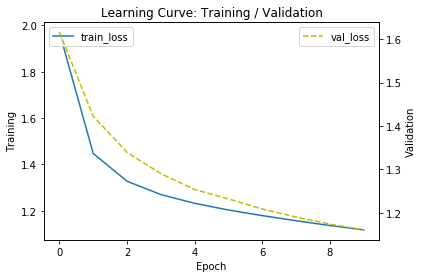

In [10]:
def setup_lstm(inp_dim, emb_dim, units, batch_sz):
    model = tf.keras.Sequential()
    model.add(layers.Embedding(inp_dim, emb_dim, batch_input_shape=[batch_sz, None]))
    model.add(layers.LSTM(
        units,
        return_sequences=True,
        stateful=True,
        recurrent_initializer='glorot_uniform'
    ))
    model.add(layers.Dense(inp_dim))
    return model

## Setup
inp_dim = vocab.size
emb_dim = 256
units = 1024
batch_size = 64

if 'model' in globals():
    print("Clean up old model!")
    tf.keras.backend.clear_session()
    del model

model = setup_lstm(inp_dim, emb_dim, units, batch_size)
model.summary()

## Training
epochs = 10
checkpoint = './models/lstm_{epoch}'
history = run_training(model, train_set, val_set, epochs, checkpoint)

## Plot
plot_history(history)

We observe the LSTM layer is exactly 4 times larger than the simple RNN.
This is plausible because the LSTM units have 3 aditional gates with a trainable parameter, each.

We obtain a proper shaped learning curve with continuously progress.
The learning curve does not yet saturate, such that further epochs would be reasonable.
The curve ends up with a lager slope than the RNN model,
which indecates that the LSTM would improve evenmore with further epochs.

In [11]:
## Run!
checkpoints = [
        './models/lstm_2',
        './models/lstm_4',
        './models/lstm_6',
        './models/lstm_8',
        './models/lstm_10'
    ]

## Take a sample from the raining set
if not 'sample' in globals():
    for batch in train_set.take(1):
        sample = bytes([vocab[i] for i in batch[0].numpy()[0]]).decode('utf-8')
print("\n--- Original Y: ---\n", sample)

for checkpoint, text, metches in eval_qualitatively(
    checkpoints,
    lambda: setup_lstm(inp_dim, emb_dim, units, batch_sz=1),
    sample
):
    print("\n--- Checkpoint: ", checkpoint, " Metch: ", (metches.mean()*100),"% ---\n", text)


--- Original Y: ---
 ld not
sell him an hour from her beholding, I, considering
how honour would become such a person. 

--- Checkpoint:  ./models/lstm_2  Metch:  55.55555555555556 % ---
 e hot 
a  tomfeder ng r aoom ter heaold ng 
Wiw tewour tiuld he ome toch a srason 

--- Checkpoint:  ./models/lstm_4  Metch:  55.55555555555556 % ---
   hot 
tomteder,ng aonr aoom tin tefolding  a 
Iiu tewouraiiuld be ome aoch a prason 

--- Checkpoint:  ./models/lstm_6  Metch:  58.58585858585859 % ---
   tot 
Thel mim t deonr toom tin bedalding  a  tomfider,ng 
Iiu tenour iiuld be ome aoch a ponson 

--- Checkpoint:  ./models/lstm_8  Metch:  57.57575757575758 % ---
   iot 
tontider ng aonr orom ten tedalding  a 
Hin tenouraiiuld he ome aoch a prnson 

--- Checkpoint:  ./models/lstm_10  Metch:  57.57575757575758 % ---
   hot 
tomfider ng aonr arom ten tedalding  a 
Hiw tenouraiiuld be ome aoch a crnion 


# Gated Recurrent Unit (GRU)

Clean up old model!
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           17408     
_________________________________________________________________
gru (GRU)                    (64, None, 1024)          3938304   
_________________________________________________________________
dense (Dense)                (64, None, 68)            69700     
Total params: 4,025,412
Trainable params: 4,025,412
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
697/697 [==============================] - 112s 161ms/step - loss: 1.9497 - val_loss: 0.0000e+00
Epoch 2/10
697/697 [==============================] - 111s 159ms/step - loss: 1.4283 - val_loss: 1.4036
Epoch 3/10
697/697 [==============================] - 111s 159ms/step - loss: 1.3223 - val_loss: 1.3313
Epoch 4/10
697/697 [====================

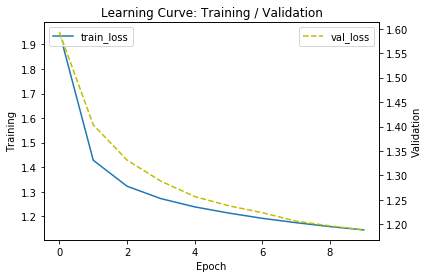

In [12]:
def setup_gru(inp_dim, emb_dim, units, batch_sz):
    model = tf.keras.Sequential()
    model.add(layers.Embedding(inp_dim, emb_dim, batch_input_shape=[batch_sz, None]))
    model.add(layers.GRU(units,
        return_sequences=True,
        stateful=True,
        recurrent_initializer='glorot_uniform'
    ))
    model.add(layers.Dense(inp_dim))
    return model

## Setup
inp_dim = vocab.size
emb_dim = 256
units = 1024
batch_size = 64

if ('model' in globals()):
    print("Clean up old model!")
    tf.keras.backend.clear_session()
    del model

model = setup_gru(inp_dim, emb_dim, units, batch_size)
model.summary()

## Training
epochs = 10
checkpoint = './models/gru_{epoch}'
history = run_training(model, train_set, val_set, epochs, checkpoint)

## Plot
plot_history(history)

In [13]:
## Run!
checkpoints = [
        './models/gru_2',
        './models/gru_4',
        './models/gru_6',
        './models/gru_8',
        './models/gru_10'
    ]

## Take a sample from the raining set
if not 'sample' in globals():
    for batch in train_set.take(1):
        sample = bytes([vocab[i] for i in batch[0].numpy()[0]]).decode('utf-8')
print("\n--- Original Y: ---\n", sample)

for checkpoint, text, metches in eval_qualitatively(
    checkpoints,
    lambda: setup_gru(inp_dim, emb_dim, units, batch_sz=1),
    sample
):
    print("\n--- Checkpoint: ", checkpoint, " Metch: ", (metches.mean()*100),"% ---\n", text)


--- Original Y: ---
 ld not
sell him an hour from her beholding, I, considering
how honour would become such a person. 

--- Checkpoint:  ./models/gru_2  Metch:  57.57575757575758 % ---
 e sot 
Thel tim tndaonr ooom tea teaold ng  a  tomstder,ng 
Wiw tewour iiuld he ome toch a srason 

--- Checkpoint:  ./models/gru_4  Metch:  57.57575757575758 % ---
 e sot 
Tael him fsdaonr ooom ten teaald ng  t  tomstder ng 
Hew tewour aiuld ne ome auch a praion 

--- Checkpoint:  ./models/gru_6  Metch:  60.60606060606061 % ---
 e sot 
Hpel him tndeonr ooom ten bedalding  a  tonfider ng 
Wiw teneuraaiuld ne ome aoch a serion 

--- Checkpoint:  ./models/gru_8  Metch:  58.58585858585859 % ---
 e tot 
Tpel mim tsdeonr ooom ten bedalding  t  tomtider ng 
Iiw tenouraaauld be ome auch a saaion 

--- Checkpoint:  ./models/gru_10  Metch:  57.57575757575758 % ---
 e tot 
ng l mim h deonr ooom tin bedalding  t  tomtider
Iiw tenourawauld be ome aoch a srnion 


# Generate Seeded Text

We've already prepered the `generate-text` function for generating an extended text based on a given seed.
Let's perform a subjectivly evaluation of our models creativity.

In [14]:
## Run!
def eval_gen_text(seed):
    checkpoints = [
            './models/rnn_10',
            './models/lstm_10',
            './models/gru_10'
        ]

    model_generators = [
        lambda: setup_rnn(inp_dim, emb_dim, units, batch_sz=1),
        lambda: setup_lstm(inp_dim, emb_dim, units, batch_sz=1),
        lambda: setup_gru(inp_dim, emb_dim, units, batch_sz=1),
    ]

    print("\n--- Seed Y: ---\n", seed)

    for checkpoint, text in eval_qualitatively(
        checkpoints,
        model_generators,
        seed,
        100
    ):
        print("\n--- Checkpoint: ", checkpoint, "---\n", text)

eval_gen_text("JULIET")


--- Seed Y: ---
 JULIET

--- Checkpoint:  ./models/rnn_10 ---
 JULIETZ
QUK[FZ
QU[QUK[
J[Q[Q[QUV$3
QUQ3
QUS[QUB
QU[Z
Q[QU$Z
QUXZ
QUV[Z
X$[
Q[
HZ
WZ
QUZ$$[
Q[W[Z[
$$[
J
QU

--- Checkpoint:  ./models/lstm_10 ---
 JULIETUONIUGHUS:
All too hollow! for visitations dog! have I conquer'd
His own thy care of supper is mor

--- Checkpoint:  ./models/gru_10 ---
 JULIET:
Away, old lord!

KING HENRY VI:
For him, brave leave, what bloody days!
Where 'will you call'


As we observe, only GRU is after 10 epochs able to generate a text-like output based on a short seed.

### Try a longer Seed

However, if we come up with a longer seed, all three models are able to create text-like outputs.
Here we use a phrase the model should already know:

In [15]:
eval_gen_text("Who is of Rome worse hated than of you")


--- Seed Y: ---
 Who is of Rome worse hated than of you

--- Checkpoint:  ./models/rnn_10 ---
 Who is of Rome worse hated than of your lord, and hotly creeping of thy petter swords!
King Henry, brought them. You see thee old,
Have 

--- Checkpoint:  ./models/lstm_10 ---
 Who is of Rome worse hated than of you,
That Harry Mowmork bid her all; Lord blings within.
That from my soul thou heave enough.

SIMP

--- Checkpoint:  ./models/gru_10 ---
 Who is of Rome worse hated than of you:
And so far enter'd here to me: 'Shllan's fair
Is red as:
We privy stuff for idle! come, deam, t


# Conclusion

In this assignment we learned how to setup and employ an RNN with an API such as Keras.
We tested 3 different sub-types of RNN-layers: SimpleRNN, LSTM and GRU.
We employed those layers to reproduce and generate text.
The experiment results show:
GRU performs best compared to similar RNN and LSTM models.
This is plausible, bacause GRU is the later invention.

- LSTM: https://www.bioinf.jku.at/publications/older/2604.pdf (1997)

- GRU: https://arxiv.org/abs/1406.1078 (2014)

Nevertheless, nowadays, employing an RNN for text generation is quite naive, since Generative Adversarial Networks are in the competition.